# Automatic Robot Classification in Movies

## Overview
There are lots of robots in various movies. Some robots might be similar, but some others looks different. 
We can guess that robots in movie have a kind of geological tree, and it might be generated automatically if we have enough data. In this notebook, I propose simple possibility of robot classification. 

## Environment
* Data: Robots in Film (http://www.filmsite.org/robotsinfilm1.html ~ robotsinfilm12.html)
* Sub-data: nltk.corpus.movie_reviews
* Programming: Jupyter 4.1.0 with Python 3.5.1

## Sentiments of robot

### Overview
I checked simple sentiment-positive/negative of each robots in movie with IMDB movie review corpus

In [3]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
 
def word_feats(words):
    return dict([(word, True) for word in words])


negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')


negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

negcutoff = len(negfeats)*3/4
poscutoff = len(posfeats)*3/4

#
trainfeats = posfeats+negfeats 
testfeats = negfeats[751:1000] + posfeats[751:1000]
print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()


train on 2000 instances, test on 498 instances
accuracy: 0.9738955823293173
Most Informative Features
                  avoids = True              pos : neg    =     13.0 : 1.0
              astounding = True              pos : neg    =     12.3 : 1.0
                    slip = True              pos : neg    =     11.7 : 1.0
             outstanding = True              pos : neg    =     11.5 : 1.0
               ludicrous = True              neg : pos    =     11.0 : 1.0
             fascination = True              pos : neg    =     11.0 : 1.0
               insulting = True              neg : pos    =     11.0 : 1.0
                    3000 = True              neg : pos    =     11.0 : 1.0
                   sucks = True              neg : pos    =     10.6 : 1.0
                  hatred = True              pos : neg    =     10.3 : 1.0


In [26]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

## pre-crawled data from website
robot_raw1 =  pd.read_csv('film15.csv')

## cleansing
robot_raw=robot_raw1.replace(np.nan, "")
robot_raw = robot_raw[3:]
robot_raw.price=robot_raw.price.replace("", 0)
def split_1(str):
    return str.split(")", 1)[1]
robot_raw.Contents = robot_raw.Contents.apply(split_1)


In [27]:
## sentiment classification

from IPython.display import Image, HTML
from IPython.display import display
from io import BytesIO
from glob import glob

import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import *

robot_class=classifier.classify_many(robot_raw.Contents.apply(word_feats))
robot_raw['class'] = robot_class
print(robot_class)
robot_class.count('pos')



['neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg'

4

## Tf-Idf distance based classification
The tf-idf, or term frequency-inverse document frequency, is a weight that ranks the importance of a term in its contextual document corpus. Term frequency is calculated as normalized frequency, a ratio of the number of occurrences of a word in its document to the total number of words in its document. 

In [32]:
## distance

import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import *
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

def get_tokens(text):
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(string.punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    return tokens


tokens = []
for i in robot_raw.Contents:
    tokens.extend(get_tokens(i))

ps_filter= [")", "(", ".","nan", "``", "''", ":", "...", "!", "?", "'s", "'", "'m", "n't", "robot", "like"]
filtered = [w for w in tokens if not w in stopwords.words('english')+ps_filter]

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(filtered, stemmer)

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

token_dict = {}

for strs in robot_raw.Contents:
    lowers = strs.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[strs] = no_punctuation

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())


In [38]:
tokens


['tik-tok',
 '(',
 'the',
 'machine',
 'man',
 ')',
 'tik-tok',
 'first',
 'appeared',
 'in',
 'film',
 'in',
 'the',
 'fairylogue',
 'and',
 'radio-plays',
 '(',
 '1908',
 ')',
 ',',
 'presented',
 'in',
 'baum',
 "'s",
 'live',
 'travelogue',
 'stage',
 'presentation',
 '(',
 'with',
 'tik-tok',
 '-',
 'the',
 'machine',
 'man',
 ',',
 'portrayed',
 'by',
 'wallace',
 'illington',
 ')',
 '.',
 'the',
 'multi-media',
 'presentation',
 'was',
 'a',
 'mix',
 'of',
 'live-action',
 ',',
 'hand-tinted',
 "'magic",
 'lantern',
 "'",
 'slides',
 ',',
 'film',
 ',',
 'and',
 'baum',
 "'s",
 'own',
 'narration',
 '.',
 'the',
 'cast',
 'of',
 'the',
 'fairylogue',
 'and',
 'radio-plays',
 '(',
 '1908',
 ')',
 'is',
 'tik-tok',
 'to',
 'the',
 'left',
 'of',
 'baum',
 '?',
 '[',
 'note',
 ':',
 'tik-tok',
 'reappeared',
 'much',
 'later',
 'as',
 'the',
 'mustached',
 'tik-tok',
 'in',
 'disney',
 "'s",
 'film',
 'return',
 'to',
 'oz',
 '(',
 '1985',
 ')',
 '.',
 'see',
 'later',
 'entry',
 '

### Clustering
K-means clustering is simple and easy to understand and visualize. 
I can get better result to iterate k-means multiple times and choose the clustering that minimizes overall error.

In [391]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfs)

clusters = km.labels_.tolist()

robot_raw["clusters"]=clusters
robot_raw['clusters'].value_counts() 

CPU times: user 103 ms, sys: 2.32 ms, total: 105 ms
Wall time: 106 ms


2    75
1    50
3    38
0    30
4     6
Name: clusters, dtype: int64

In [ ]:
print(posfeats[1])


In [392]:
## check the results with movie name. 
rd = {'0':set(robot_raw.MovieName[robot_raw.clusters==0]),'1':set(robot_raw.MovieName[robot_raw.clusters==1]),'2':set(robot_raw.MovieName[robot_raw.clusters==2]),'3':set(robot_raw.MovieName[robot_raw.clusters==3]), '4':set(robot_raw.MovieName[robot_raw.clusters==4]) }
rdf = pd.DataFrame.from_dict(rd, orient='index')
rdf=rdf.fillna(" ").transpose()

pd.options.display.max_rows = 999

display(rdf)



,1,3,4,0,2
0,Edward Scissorhands,Transmorphers,Making Mr. Right,Message From Space,Electric Dreams
1,Undersea Kingdom,The Master Mystery,Sky Captain and the World of Tomorrow,Oblivion,The Fairylogue and Radio-Plays
2,The Last Starfighter,Runaway,Target Earth,Metropolis,1960s 1980s 2000s Astroboy
3,Cyborg,1940 serial Dr. Satan's Robot,Back to the Future Part II,Dr. Goldfoot and the Bikini Machine,And You Thought Your Parents Were Weird
4,Automatons,Dr. Who & the Daleks,Rottweiler,Her,The Santa Clause 2
5,Deadly Friend,Bill & Ted's Bogus Journey,Superman III,Guyver,The Terminator
6,Darkman,Jason and the Argonauts,,The Mechanical Man,The Mysterians
7,Death Machine,Inspector Gadget,,The Matrix,Tobor the Great
8,Artificial Intelligence: A.I.,Colossus: The Forbin Project,,The Shape of Things to Come,The Aztec Mummy Against the Humanoid Robot
9,*batteries not included,ROBOTS,,Cherry 2000,Metropolis


### Cluster results with keywords

In [393]:
from __future__ import print_function
import codecs

vocab_frame = pd.DataFrame({'words': filtered}, index = stemmed)

terms = tfidf.get_feature_names()

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order = []
for i in range(num_clusters):
    zi = order_centroids[i, :50]
    order.append(zi)

order_c =[]
for i in range(num_clusters):
    iz = order[i]
    for j in range(1,num_clusters):
        if i!=j:
            iz = [x for x in iz if not x in order[j]]
    order_c.append(iz)

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order[i]: #replace 6 with n words per cluster
        ii = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        print(' %s' % ii, end=',')
       
    print() #add whitespace
    print() #add whitespace
    
    print()
    print("Cluster %d Movie:" % i, end='')
    for title in robot_raw.MovieName[robot_raw.clusters==i]:
        print(' %s,' % title, end='')
    
    print()
    print()
    print("Cluster %d Robot:" % i, end='')
    for ts in robot_raw.RobotName[robot_raw.clusters==i]:
        if len(title)>1:
            print(' %s,' % ts, end='')
        
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: ,, nan, nan, nan, nan, nan, android, nan, nan, nan, series, oz, robots, film, trace, tv, boy, solo, human, tobor, evolved, -, dr., nan, tin, astro, nan, year, original, tik-tok, man, soldiers, nan, zevo, gigantor, head, programmed, quite, robodoc, carson, austin, william, characters, created, aka, sci-fi, roboman, otomo, robocop, featured,


Cluster 0 Movie: The Mechanical Man , Metropolis , Gog , Forbidden Planet , The Creation of the Humanoids , Dr. No , Dr. Goldfoot and the Bikini Machine , The Terrornauts , Fantastic Planet , Sleeper , Demon Seed , Message From Space , The Shape of Things to Come, Star Odyssey , Galaxina , Blade Runner , Cherry 2000 , Spaceballs , Total Recall , Guyver , Flubber , The Matrix , The Adventures of Pluto Nash , Treasure Planet , Transformers , RoboDoc , Her , Oblivion , The LEGO Movie , Chappie ,

Cluster 0 Robot: , , Gog and Magog NOVAC Super-Computer, Robby the Robot Poster, Humanoids Dr. Raven's Closing Speec

## Visualization with plot.ly
### Histogram

In [293]:
robots = robot_raw
import plotly.plotly as py
import plotly.graph_objs as go

temp= robot_raw["Year"].value_counts()

data = [
    go.Histogram(
        x=robot_raw["Year"],
    )
]
#help(py.offline.plot)
py.iplot(data)

#robot_raw.to_csv("~/Documents/robot_raw1.csv")


## Histogram with clustering results

In [400]:

data1 = [
    go.Histogram(
        x=robot_raw.Year[robot_raw.clusters==0],
        opacity = 0.70
    ), go.Histogram(
        x=robot_raw.Year[robot_raw.clusters==1],
        opacity = 0.70
    ), go.Histogram(
        x=robot_raw.Year[robot_raw.clusters==2],
        opacity = 0.70
    ),  go.Histogram(
        x=robot_raw.Year[robot_raw.clusters==3],
        opacity = 0.70
    ), go.Histogram(
        x=robot_raw.Year[robot_raw.clusters==4],
        opacity = 0.70
    )
]

layout = go.Layout(
    barmode='overlay'
)
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

### Scatter plot with clusters

In [401]:

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

MDS()
dist = 1 - cosine_similarity(tfs)
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

KeyError: 0

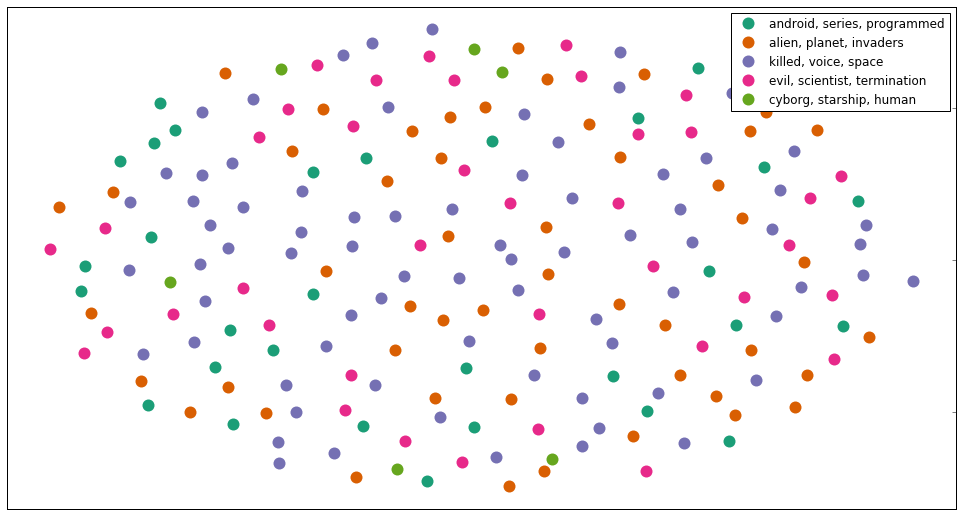

In [402]:

%matplotlib inline 


#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=robot_raw.clusters, title=robot_raw.MovieName)) 

#group by cluster
groups = df.groupby('label')

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'android, series, programmed', 
                 1: 'alien, planet, invaders', 
                 2: 'killed, voice, space', 
                 3: 'evil, scientist, termination', 
                 4: 'cyborg, starship, human'}

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'][0:20], size=8)  

    
py.iplot_mpl(fig)   
#plt.show() 

In [403]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

df = pd.DataFrame(dict(x=xs, y=ys, label=robot_raw.clusters, title=robot_raw.MovieName, image = robot_raw.image)) 
groups = df.groupby('label')


trace0 = go.Scatter(
    x=df.x[df.label==0],
    y=df.y[df.label==0],
    mode='markers',
    text = df.title[df.label==0], 
    name= cluster_names[0],
    marker=dict(
        size='10',
        color = df.label[0], #set color equal to a variable
    )
)
trace1 = go.Scatter(
    x=df.x[df.label==1],
    y=df.y[df.label==1],
    mode='markers',
    text = df.title[df.label==1], 
    name= cluster_names[1],
    marker=dict(
        size='10',
        color = df.label[1], #set color equal to a variable
    )
)
trace2 = go.Scatter(
    x=df.x[df.label==2],
    y=df.y[df.label==2],
    mode='markers',
    text = df.title[df.label==2], 
    name= cluster_names[2],
    marker=dict(
        size='10',
        color = df.label[2], #set color equal to a variable
    )
)
trace3 = go.Scatter(
    x=df.x[df.label==3],
    y=df.y[df.label==3],
    mode='markers',
    text = df.title[df.label==3], 
    name= cluster_names[3],
    marker=dict(
        size='10',
        color = df.label[3], #set color equal to a variable
    )
)
trace4 = go.Scatter(
    x=df.x[df.label==4],
    y=df.y[df.label==4],
    mode='markers',
    text = df.title[df.label==4], 
    name= cluster_names[4],
    marker=dict(
        size='10',
        color = df.label[4], #set color equal to a variable
    )
)


layout = {
    'xaxis': {
        'showticklabels': False,
        'autotick': True,
        'showgrid': False,
        'zeroline': False,
    },
    'yaxis': {
        'showticklabels': False,
        'autotick': True,
        'showgrid': False,
        'zeroline': False,
    },
    'shapes': [
        {
            'type': 'circle',
            'xref': 'x',
            'yref': 'y',
            'x0': min(df.x[df.label==0]),
            'y0': min(df.y[df.label==0]),
            'x1': max(df.x[df.label==0]),
            'y1': max(df.y[df.label==0]),
            'opacity': 0.15,
            'fillcolor': 'blue',
            'line': {
                'color': 'blue',
            },
            
        },
        {
            'type': 'circle',
            'xref': 'x',
            'yref': 'y',
            'x0': min(df.x[df.label==1]),
            'y0': min(df.y[df.label==1]),
            'x1': max(df.x[df.label==1]),
            'y1': max(df.y[df.label==1]),
            'opacity': 0.15,
            'fillcolor': 'orange',
            'line': {
                'color': 'orange',
            },
           
        },
        {
            'type': 'circle',
            'xref': 'x',
            'yref': 'y',
            'x0': min(df.x[df.label==2]),
            'y0': min(df.y[df.label==2]),
            'x1': max(df.x[df.label==2]),
            'y1': max(df.y[df.label==2]),
            'opacity': 0.15,
            'fillcolor': 'violet',
            'line': {
                'color': 'violet',
            },
           
        },
        {
            'type': 'circle',
            'xref': 'x',
            'yref': 'y',
            'x0': min(df.x[df.label==3]),
            'y0': min(df.y[df.label==3]),
            'x1': max(df.x[df.label==3]),
            'y1': max(df.y[df.label==3]),
            'opacity': 0.15,
            'fillcolor': 'red',
            'line': {
                'color': 'red',
            },
         
        },
        {
            'type': 'circle',
            'xref': 'x',
            'yref': 'y',
            'x0': min(df.x[df.label==4]),
            'y0': min(df.y[df.label==4]),
            'x1': max(df.x[df.label==4]),
            'y1': max(df.y[df.label==4]),
            'opacity': 0.15,
            'fillcolor': 'yellow',
            'line': {
                'color': 'yellow',
            },
       
        },
    ],
    'height': 600,
    'width': 800,
}

fig = {
    'data': [trace0, trace1, trace2, trace3, trace4],
    'layout': layout,
}
fig1 = go.Figure(data=[trace0, trace1, trace2, trace3, trace4], layout=layout)
py.iplot(fig1)

KeyError: 0

In [1]:

import plotly.plotly as py
from plotly.graph_objs import *

import networkx as nx

G=nx.Graph()
G.add_node(df.title)
G.add_edge(pos)

edge_trace = Scatter(
    x=[], 
    y=[], 
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[], 
    y=[], 
    text=[],
    mode='markers', 
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

NameError: name 'df' is not defined

In [104]:
print(pos)

  (0, 2794)	0.0707514766688
  (0, 5081)	0.0535604203241
  (0, 2066)	0.0504203305327
  (0, 417)	0.0879425330136
  (0, 4684)	0.0418680289173
  (0, 3806)	0.0227426646243
  (0, 6784)	0.0736044396186
  (0, 337)	0.0879425330136
  (0, 2386)	0.05114827452
  (0, 756)	0.0414615651858
  (0, 3221)	0.0662498351272
  (0, 4033)	0.0612666794759
  (0, 5)	0.0253787930583
  (0, 1671)	0.0574929819215
  (0, 40)	0.0879425330136
  (0, 3299)	0.081597825612
  (0, 2866)	0.0574929819215
  (0, 2747)	0.0544548336882
  (0, 2926)	0.0574929819215
  (0, 2757)	0.081597825612
  (0, 8626)	0.0662498351272
  (0, 8424)	0.0574929819215
  (0, 7641)	0.0879425330136
  (0, 5083)	0.0535604203241
  (0, 6150)	0.081597825612
  :	:
  (201, 7768)	0.0704793528636
  (201, 8437)	0.0474374549206
  (201, 6660)	0.0267761664629
  (201, 4060)	0.0532565049014
  (201, 2971)	0.0661164605457
  (201, 3342)	0.0889526759196
  (201, 5953)	0.0541619072698
  (201, 510)	0.0831336259388
  (201, 6866)	0.0503503926327
  (201, 5)	0.0359716417414
  (201, 128

In [365]:
## image preview function
def disp_image(url):
    if len(url)>3:
        display(Image(url))
    else:
       display(Image("https://upload.wikimedia.org/wikipedia/en/4/48/Blank.JPG"))
        
def spl_url(url):
    r_url = url.split(';')[0].strip()
    print(len(r_url))
    if (len(r_url)<3):
        r_url="https://upload.wikimedia.org/wikipedia/en/4/48/Blank.JPG"
    elif(r_url[len(r_url)-2]=='.'):
        r_url="https://upload.wikimedia.org/wikipedia/en/4/48/Blank.JPG"
    return r_url;


robot_raw['image']=robot_raw["image"].apply(spl_url)

#robot_raw['image'].apply(disp_image)



0
58
44
49
48
42
58
47
50
48
45
54
55
53
54
51
46
54
58
44
46
49
46
41
45
52
47
55
54
46
52
43
40
52
56
62
43
45
52
40
45
55
50
52
45
50
39
43
44
48
50
52
43
44
45
43
44
52
45
44
53
58
54
48
58
51
40
44
47
55
53
54
45
43
44
54
45
51
42
47
45
44
50
57
49
45
43
45
43
46
42
48
48
53
59
52
47
45
51
50
47
48
54
43
45
51
41
48
43
43
44
56
46
54
52
43
41
47
41
39
51
51
51
44
54
46
43
43
47
43
45
45
51
48
40
53
39
47
52
54
49
52
49
48
50
50
49
56
45
41
49
44
38
47
57
50
56
53
41
42
55
53
48
46
42
52
46
52
51
41
49
46
37
51
47
55
52
43
41
50
39
39
49
50
52
49
49
59
45
48
50
51
44
50
49
53
50
48
52
